<a href="https://colab.research.google.com/github/jadraque94/Image_ISAR/blob/main/BE_NOTE_MARCELIN_JADRAQUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BE NOTE - MARCELIN THALUL-DE  | JADRAQUE CHADI**

## **Partie I - Analyse de donnees ISAR**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import numpy as np
from skimage.transform import warp_polar, rotate, rescale, resize
from skimage.registration import phase_cross_correlation
from glob import glob
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import geometric_transform
from scipy.ndimage import rotate
import cv2
from sklearn import model_selection
from sklearn import neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier
import time
from  sklearn.metrics import classification_report, confusion_matrix
import scipy.stats


In [3]:
files = glob("BE/*.bmp") #Get the bmp files of in folder

Dict = {}
for f in files:
    fullPic = f.split('/')[1]
    shortPic = fullPic.split('.bmp')[0]
    classPic = shortPic.split('_')[0]
    noPic = shortPic.split('_')[1]
    try:
        Dict[classPic] +=1
    except KeyError as e:
        Dict[classPic] = 1
print(Dict)

{}


In [4]:
# Fonction load_bdd pour la creation de la matrice de donnees et de labels
# On utilise les labels 0 1 2 3 4 respectivement pour les cilbles A10 F4 F14 F15 F16

def load_bdd(path):
    images = glob(path + "/*")
    data = np.zeros((len(images),128*128))
    labels = []
    
    dictLabels = {
        'A10': 0,
        'F4' :1,
        'F14': 2,
        'F15' : 3,
        'F16' : 4,
    }
    
    for (i, pth) in enumerate(images):
        img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE) #on utlise cv2.IMREAD_GRAYSCALE pour supprimer le canal multichannelet avoir une image de
        img = img[64:192,64:192] # On selectionne que les pixels au centre de l'image
        
        data[i] = img.flatten() / 255
        
        pathsplit = os.path.split(pth)  
        labels.append(dictLabels[pathsplit[1].split('_')[0]])
        
    labels = np.array(labels)
    
    return data, labels

In [ ]:
# Affichage de la matrice des donnees et des labels

print(load_bdd("images_ISAR/"))

(array([[0.00392157, 0.00392157, 0.        , ..., 0.00784314, 0.00784314,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314, 0.00392157,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.00392157,
        0.00392157],
       ...,
       [0.00784314, 0.00784314, 0.00784314, ..., 0.01176471, 0.01176471,
        0.01176471],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.00392157, 0.00784314,
        0.00784314],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]]), array([4, 4, 2, 0, 0, 2, 3, 1, 3, 1, 3, 1, 2, 3, 3, 2, 2, 1, 4, 1, 1, 3,
       4, 3, 3, 3, 1, 4, 1, 1, 4, 2, 2, 3, 3, 2, 1, 3, 1, 3, 1, 3, 0, 2,
       2, 0, 4, 4, 0, 4, 4, 2, 0, 3, 3, 2, 1, 1, 3, 2, 2, 1, 3, 1, 3, 4,
       1, 3, 4, 3, 3, 4, 3, 4, 1, 3, 1, 3, 1, 2, 2, 3, 1, 1, 2, 3, 3, 0,
       2, 4, 4, 0, 0, 4, 4, 0, 0, 2, 3, 3, 1, 3, 2, 2, 3, 1, 1, 2, 3, 3,
       1, 3, 1, 4, 1, 3, 4, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3

## **Partie II -  Extraction de caracteristique - image polaire**

In [ ]:
def polaire(img):
    N_r = 50
    N_theta = 50
    R_max = 50
    R_min = 0
    
    x0 = img.shape[0] / 2
    y0 = img.shape[1] / 2

    delta_theta = 2 * np.pi / (N_theta - 1)
    delta_r = (R_max - R_min) / (N_r - 1)

    r_m = np.linspace(R_min, R_max,N_r)
    theta_n = np.linspace(-1 * np.pi, np.pi, N_theta)
 
    r_m, theta_n = np.meshgrid(r_m, theta_n)
    image_polaire = img[np.int8(np.floor(x0 + r_m * np.cos(theta_n))), np.int8(np.floor(y0 + r_m * np.sin(theta_n)))]
    
    return image_polaire

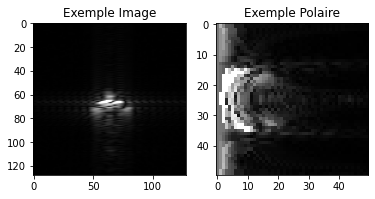

In [ ]:
# Affichage Image Polaire

exemple_path = "images_ISAR/F4_1.bmp"
exemple_image = cv2.imread(exemple_path)[64:192,64:192]

plt.subplot(121)
plt.title("Exemple Image")
plt.imshow(exemple_image)

image_polaire = polaire(exemple_image)
plt.subplot(122)
plt.title("Exemple Polaire")
plt.imshow(image_polaire)

plt.show()

In [ ]:
# Dimension de la nouvelle image 5 :
print("Dimension: ", image_polaire.shape)

Dimension:  (50, 50, 3)


In [ ]:
La nouvelle image polaire a une resolution de 50x50

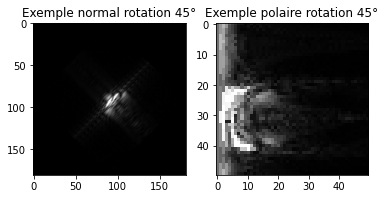

In [ ]:
# Rotatation de 45 degree et affichage

rotated_image = rotate(exemple_image, 45)
rotated_polar_image = polaire(rotated_image)

plt.figure()

plt.subplot(121)
plt.imshow(rotated_image)
plt.title("Exemple normal rotation 45°")

plt.subplot(122)
plt.imshow(rotated_polar_image)
plt.title("Exemple polaire rotation 45°")

plt.show()

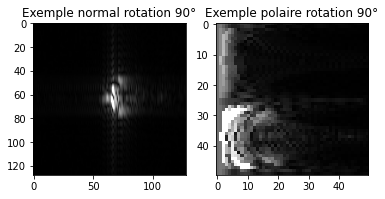

In [ ]:
# Rotatation de 90 degree et affichage

rotated_image = rotate(exemple_image, 90)
rotated_polar_image = polaire(rotated_image)

plt.figure()

plt.subplot(121)
plt.imshow(rotated_image)
plt.title("Exemple normal rotation 90°")

plt.subplot(122)
plt.imshow(rotated_polar_image)
plt.title("Exemple polaire rotation 90°")

plt.show()

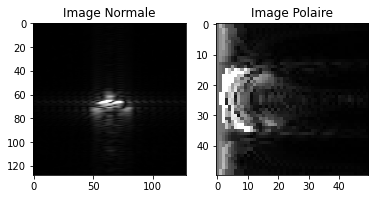

In [ ]:
# Changement d'echelle et affichage

resized_image = rescale(exemple_image, 1, multichannel=True)
rezized_image_polaire = polaire(resized_image)

plt.figure()

plt.subplot(121)
plt.imshow(resized_image)
plt.title("Image Normale")

plt.subplot(122)
plt.imshow(rezized_image_polaire)
plt.title("Image Polaire")

plt.show()

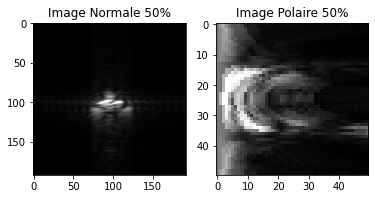

In [ ]:
# Changement d'echelle et affichage

resized_image = rescale(exemple_image, 1.5, multichannel=True)
rezized_image_polaire = polaire(resized_image)

plt.figure()

plt.subplot(121)
plt.imshow(resized_image)
plt.title("Image Normale 50%")

plt.subplot(122)
plt.imshow(rezized_image_polaire)
plt.title("Image Polaire 50%")

plt.show()

In [ ]:
#Nouvelle fonctions polaire2 avec les vecteurs sur l'axe-r et l'axe tetha:

def polaire2(img):
    N_r = 50
    N_theta = 50
    R_max = 50
    R_min = 0
    
    x0 = img.shape[0] / 2
    y0 = img.shape[1] / 2

    delta_theta = 2 * np.pi / (N_theta - 1)
    delta_r = (R_max - R_min) / (N_r - 1)

    r_m = np.linspace(R_min, R_max,N_r)
    theta_n = np.linspace(-1 * np.pi, np.pi, N_theta)
 
    r_m, theta_n = np.meshgrid(r_m, theta_n)
    image_polaire = img[np.int8(np.floor(x0 + r_m * np.cos(theta_n))), np.int8(np.floor(y0 + r_m * np.sin(theta_n)))]
    
    Ir = np.sum(image_polaire,axis=0) / np.sum(image_polaire)
    I_theta = np.sum(image_polaire,axis=1) / np.sum(image_polaire)
    
    return image_polaire, Ir, I_theta

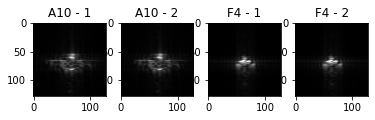

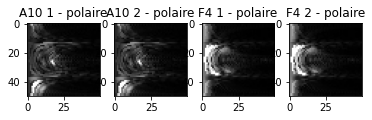

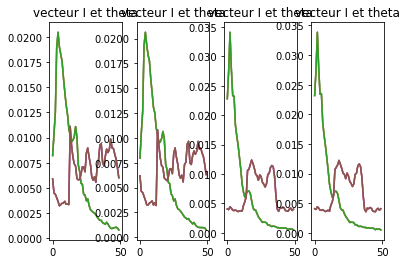

In [ ]:
# Comparons Maintenant deux images d'une meme cible avec deux images d'une autre cible et etudions les vecteurs

image_cible_1_0 = cv2.imread('images_ISAR/A10_1.bmp')[64:192,64:192] 
image_cible_1_1 = cv2.imread('images_ISAR/A10_2.bmp')[64:192,64:192]

image_cible_2 = cv2.imread('images_ISAR/F4_1.bmp')[64:192,64:192]
image_cible_3 = cv2.imread('images_ISAR/F4_2.bmp')[64:192,64:192]


plt.figure()

plt.subplot(141)
plt.imshow(image_cible_1_0)
plt.title("A10 - 1")

plt.subplot(142)
plt.imshow(image_cible_1_1)
plt.title("A10 - 2")

plt.subplot(143)
plt.imshow(image_cible_2)
plt.title("F4 - 1")

plt.subplot(144)
plt.imshow(image_cible_3)
plt.title("F4 - 2")

img1_polar, I_r1, I_theta1 = polaire2(image_cible_1_0)
img2_polar, I_r2, I_theta2 = polaire2(image_cible_1_1)
img3_polar, I_r3, I_theta3 = polaire2(image_cible_2)
img4_polar, I_r4, I_theta4 = polaire2(image_cible_3)


plt.figure()

plt.subplot(141)
plt.imshow(img1_polar)
plt.title("A10 1 - polaire")

plt.subplot(142)
plt.imshow(img2_polar)
plt.title("A10 2 - polaire")

plt.subplot(143)
plt.imshow(img3_polar)
plt.title("F4 1 - polaire")

plt.subplot(144)
plt.imshow(img3_polar)
plt.title("F4 2 - polaire")

plt.figure()

plt.subplot(141)
plt.plot(I_r1)
plt.plot(I_theta1)
plt.title("vecteur I et theta")

plt.subplot(142)
plt.plot(I_r2)
plt.plot(I_theta2)
plt.title("vecteur I et theta")

plt.subplot(143)
plt.plot(I_r3)
plt.plot(I_theta3)
plt.title("vecteur I et theta")

plt.subplot(144)
plt.plot(I_r4)
plt.plot(I_theta4)
plt.title("vecteur I et theta")

plt.show()

In [ ]:
image_cible_1_0_rotated = rotate(image_cible_1_0, 45)
image_cible_1_0_polaire, Ir_rotated, I_theta_rotated = polaire2(image_cible_1_0_rotated)


dist1 = np.linalg.norm(I_r1 - Ir_rotated)

dist2 = np.linalg.norm(I_theta1 - I_theta_rotated)

print("Distance euclidienne entre les vecteurs")
print("Distance Vecteur Ir  : ", dist1)
print("Distance Vecteur Itetha : ", dist2)

Distance euclidienne entre les vecteurs
Distance Vecteur Ir  :  0.006102515006728007
Distance Vecteur Itetha :  0.034803539662670274


In [ ]:
image_rotated = rotate(image_cible_1_0, 90)
image_polaire = polaire(image_cible_1_0)

image_rotated_polar = polaire(image_rotated)

# la cross correlation revient a faire le produit de la transformee de Fourrier
shifts, error, phasediff = phase_cross_correlation(image_polaire, image_rotated_polar)
print(f"Translation estimée sur le vecteur Itheta pour une rotation de 90 est de {-shifts[0]} pixels")

Translation estimée sur le vecteur Itheta pour une rotation de 90 est de 13.0 pixels


## **Partie III -  Classification : reconnaissance**

In [ ]:
# Fontions DecripteursBDD.py

def DecripteursBDD(path):
    X, y = load_bdd(path) 
    R_max = 50

    data = np.zeros((X.shape[0],R_max * 2))

    for i in range(X.shape[0]):
        image = X[i].reshape((128,128))                
        image_polar, Ir, I_theta = polaire2(image)  
        data[i] = np.hstack((Ir, I_theta))
        
    return {'data': data, 'labels': y}   

data = DecripteursBDD("images_ISAR/")
print(data)
print(f"La taille de cette matrice est: {len(data['data'])}", )

{'data': array([[0.05323994, 0.05177744, 0.053535  , ..., 0.00788977, 0.00921115,
        0.01191805],
       [0.09536676, 0.07403287, 0.06748082, ..., 0.00839757, 0.00833576,
        0.01076408],
       [0.12988998, 0.10922983, 0.09731051, ..., 0.01572942, 0.01586186,
        0.01765485],
       ...,
       [0.02020288, 0.02953874, 0.05296344, ..., 0.00983561, 0.00935712,
        0.00916573],
       [0.08472306, 0.07684683, 0.06420869, ..., 0.0129864 , 0.01105083,
        0.00908847],
       [0.08184619, 0.0572795 , 0.0546219 , ..., 0.01044422, 0.01001412,
        0.01150982]]), 'labels': array([4, 4, 2, 0, 0, 2, 3, 1, 3, 1, 3, 1, 2, 3, 3, 2, 2, 1, 4, 1, 1, 3,
       4, 3, 3, 3, 1, 4, 1, 1, 4, 2, 2, 3, 3, 2, 1, 3, 1, 3, 1, 3, 0, 2,
       2, 0, 4, 4, 0, 4, 4, 2, 0, 3, 3, 2, 1, 1, 3, 2, 2, 1, 3, 1, 3, 4,
       1, 3, 4, 3, 3, 4, 3, 4, 1, 3, 1, 3, 1, 2, 2, 3, 1, 1, 2, 3, 3, 0,
       2, 4, 4, 0, 0, 4, 4, 0, 0, 2, 3, 3, 1, 3, 2, 2, 3, 1, 1, 2, 3, 3,
       1, 3, 1, 4, 1, 3, 4, 1, 3, 3, 2

In [ ]:
# Fonction reconnaissance.py

X_train, X_test, y_train, y_test = model_selection.train_test_split(data['data'], data['labels'], test_size=1/3)

print("Base d'apprentissage : ", X_train.shape, y_train.shape)
print("Base de test         : ", X_test.shape, y_test.shape)

Base d'apprentissage :  (540, 100) (540,)
Base de test         :  (270, 100) (270,)


(540, 50)
temp de calcul 0.0005788803100585938 pour k=1
temp de calcul 0.0006251335144042969 pour k=2
temp de calcul 0.0007479190826416016 pour k=3
temp de calcul 0.0006737709045410156 pour k=4
temp de calcul 0.0008349418640136719 pour k=5
temp de calcul 0.0006039142608642578 pour k=6
temp de calcul 0.0006101131439208984 pour k=7
temp de calcul 0.0006411075592041016 pour k=8
temp de calcul 0.0005648136138916016 pour k=9


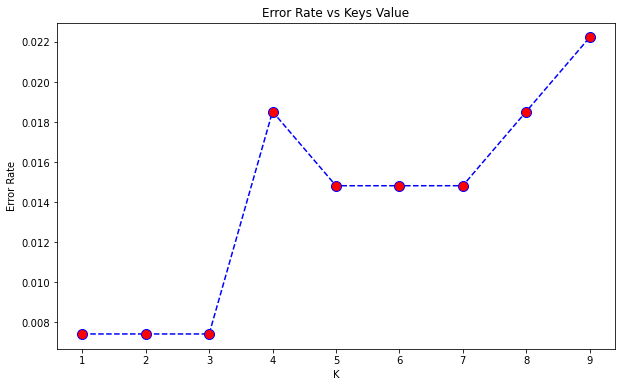


C1 Taux de classification: 0.9925925925925926

Matrice de distance :
[[0.00807277 0.00808449 0.01437348 ... 0.11486898 0.11504422 0.11515987]
 [0.00302303 0.00840733 0.01101614 ... 0.12451744 0.12460179 0.12470852]
 [0.00705712 0.00991985 0.01169906 ... 0.17689989 0.1770898  0.17722723]
 ...
 [0.00431939 0.00517388 0.00746122 ... 0.13346918 0.13363623 0.13485052]
 [0.00850786 0.01438344 0.01477593 ... 0.12578724 0.12593992 0.12597053]
 [0.00282804 0.00466955 0.00597723 ... 0.16224581 0.16245896 0.16252857]] [[  6 108 342 ... 490  75 206]
 [ 72 329 147 ...  75 490 206]
 [217 429 418 ... 310 491  34]
 ...
 [382 284 473 ... 443 220 269]
 [205 390  64 ... 220 146 269]
 [451   6 519 ... 490  75 206]]


In [ ]:
params = {'n_neighbors':[1, 3, 5]}

error_rate = []

print(X_train[:,:50].shape)

for i in range(1, 10):
    t_zero = time.time()
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train[:,:50], y_train)
    t_end = time.time() - t_zero
    pred_i = KNN.predict(X_test[:,:50])
    error_rate.append(np.mean(pred_i != y_test))
    #print(confusion_matrix(y_test, pred_i))
    #print(classification_report(y_test, pred_i))
    print(f"temp de calcul {t_end} pour k={i}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), error_rate, color="blue", linestyle="--", marker='o', markerfacecolor='red', markersize=10)

plt.title("Error Rate vs Keys Value")
plt.xlabel('K')
plt.ylabel('Error Rate')

plt.show()


c1 = neighbors.KNeighborsClassifier(n_neighbors=1)
c1.fit(X_train[:,:50], y_train)

y_pred = c1.predict(X_test[:,:50])
print(f"\nC1 Taux de classification: {metrics.accuracy_score(y_test, y_pred)}")

matrice_distances, m_indices = c1.kneighbors(X=X_test[:,:50], n_neighbors=y_train.shape[0], return_distance=True)

print("\nMatrice de distance :")
print(matrice_distances, m)

In [ ]:
c1_Itheta = neighbors.KNeighborsClassifier(n_neighbors=1)
c1_Itheta.fit(X_train[:,50:], y_train)

y_pred_theta = c1_Itheta.predict(X_test[:,50:])
print(f"Lorsqu'on utilise ITheta on a comme taux de classification: {metrics.accuracy_score(y_test, y_pred_theta)}")

c1_Itheta_plus_Ir = neighbors.KNeighborsClassifier(n_neighbors=1)
c1_Itheta_plus_Ir.fit(X_train, y_train)

y_pred_Itheta_plus_Ir = c1_Itheta_plus_Ir.predict(X_test)
print(f"Lorsqu'on utilise Ir + Itetha on a comme taux de classification: {metrics.accuracy_score(y_test, y_pred_Itheta_plus_Ir)}")


Lorsqu'on utilise ITheta on a comme taux de classification: 1.0
Lorsqu'on utilise Ir + Itetha on a comme taux de classification: 1.0


In [ ]:
5- Implementons le classifieur C2 en tenant compte des indices du classifieur precedents.

In [ ]:
# Implementons le classifieur C2 en utilisant la distance euclidienne comme mesure de similarite

def C2(X_train, y_train, X_test, y_test, indices, k):
    neighbors = int(0.3 * X_train.shape[0])  # On utilise que 30% percent pour ce classifieur
    y_pred = []
    indices_n = []
    
    for m in range(X_test.shape[0]):
        X_neighbors = X_train[indices[m, :neighbors]]
        labels_neighbors = y_train[indices[m, :neighbors]]
        
        dist_neighbors = np.linalg.norm(X_neighbors-X_test[m], axis=1)
        indice_neighbors = dist_neighbors.argsort()
        k_nearest_neighbors_ids = indice_neighbors[:k]
        
        
        k_nearest_neighbors_labels = labels_neighbors[k_nearest_neighbors_ids]
        y_pred.append(scipy.stats.mode(k_nearest_neighbors_labels)[0][0])
        indices_n.append(indice_neighbors)
        
    y_pred = np.array(y_pred)
    indices_n = np.array(indices_n)
    
    return y_pred, indices_n

In [ ]:

t_start = time.time()

pred_1, m_2 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 1)

t_1 = time.time()
print(f"Taux de classification pour k=1: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_1-t_start}  secondes ")

pred_2, m_1 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 3)
t_2 = time.time()
print(f"Taux de classification pour k=3: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_2-t_start}  secondes ")

pred_3, m_3 = C2(X_train[:,50:], y_train, X_test[:,50:], y_test, m_indices, 5)
t_3 = time.time()
print(f"Taux de classification pour k=5: {metrics.accuracy_score(y_test, pred_1)}  - Temps de calcul : {t_3-t_start}  secondes ")


Taux de classification pour k=1: 1.0  - Temps de calcul : 0.06743192672729492  secondes 
Taux de classification pour k=3: 1.0  - Temps de calcul : 0.10925698280334473  secondes 
Taux de classification pour k=5: 1.0  - Temps de calcul : 0.15222787857055664  secondes 
